In [1]:
import os
import pandas as pd

# Emotion code to label
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def get_ravdess_df(base_dir, dataset_type):
    data = []
    for actor_folder in sorted(os.listdir(base_dir)):
        actor_path = os.path.join(base_dir, actor_folder)
        if not os.path.isdir(actor_path): continue

        for file in sorted(os.listdir(actor_path)):
            if not file.endswith(".wav"): continue

            parts = file.split('-')
            if len(parts) < 3: continue

            emotion_code = parts[2]
            emotion = emotion_map.get(emotion_code, 'unknown')

            data.append({
                "file_path": os.path.join(actor_path, file),
                "emotion": emotion,
                "dataset": dataset_type  # Add dataset tag
            })

    return pd.DataFrame(data)

# Paths to both datasets
speech_path = "/kaggle/input/ravdess-emotional-speech-audio"
song_path = "/kaggle/input/ravdess-emotional-song-audio"

# Get DataFrames with dataset info
df_speech = get_ravdess_df(speech_path, dataset_type="speech")
df_song = get_ravdess_df(song_path, dataset_type="song")

# Combine
df = pd.concat([df_speech, df_song], ignore_index=True)

# Check
print(f"Total files: {len(df)}")
print(f"Duplicate file paths: {df.duplicated('file_path').sum()}")
print(df['dataset'].value_counts())

# Preview
df.head()


Total files: 2452
Duplicate file paths: 0
dataset
speech    1440
song      1012
Name: count, dtype: int64


,file_path,emotion,dataset
0,/kaggle/input/ravdess-emotional-speech-audio/A...,neutral,speech
1,/kaggle/input/ravdess-emotional-speech-audio/A...,neutral,speech
2,/kaggle/input/ravdess-emotional-speech-audio/A...,neutral,speech
3,/kaggle/input/ravdess-emotional-speech-audio/A...,neutral,speech
4,/kaggle/input/ravdess-emotional-speech-audio/A...,calm,speech


In [2]:
import librosa
import numpy as np
from tqdm import tqdm

def extract_mfcc(file_path, sr=16000, start_sec=0.5, end_sec=3.5,
                 n_fft=512, hop_length=256, n_mfcc=40):
    try:
        # Load audio and resample to 16kHz mono
        y, _ = librosa.load(file_path, sr=sr, mono=True)
        
        # Trim to [0.5s, 3.0s] = 2.5s segment
        start_sample = int(start_sec * sr)
        end_sample = int(end_sec * sr)
        y = y[start_sample:end_sample]

        # Pad if shorter than required
        required_len = end_sample - start_sample
        if len(y) < required_len:
            y = np.pad(y, (0, required_len - len(y)))

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                                    n_fft=n_fft, hop_length=hop_length)

        # Normalize (z-score)
        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

        return mfcc.T  # shape: (time_steps, n_mfcc)
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Apply to DataFrame
tqdm.pandas()
df["mfcc"] = df["file_path"].progress_apply(extract_mfcc) 

100%|██████████| 2452/2452 [01:28<00:00, 27.70it/s]


In [3]:
import torch

def pad_or_truncate(mfcc, target_len=156):
    """
    Pad with zeros or truncate MFCC to (target_len, 40)
    """
    if mfcc is None:
        return torch.zeros((target_len, 40), dtype=torch.float32)
    
    mfcc = torch.tensor(mfcc, dtype=torch.float32)

    # Truncate if longer
    if mfcc.shape[0] > target_len:
        mfcc = mfcc[:target_len, :]
    
    # Pad if shorter
    elif mfcc.shape[0] < target_len:
        pad_len = target_len - mfcc.shape[0]
        padding = torch.zeros((pad_len, mfcc.shape[1]), dtype=torch.float32)
        mfcc = torch.cat((mfcc, padding), dim=0)

    return mfcc

# Apply to all MFCCs in the DataFrame
df["mfcc_tensor"] = df["mfcc"].apply(lambda x: pad_or_truncate(x, target_len=184))


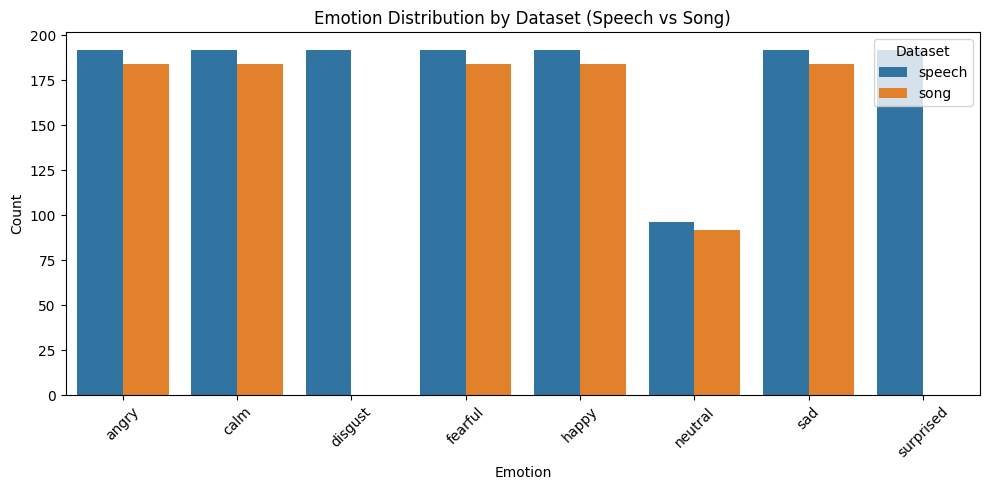

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="emotion", order=sorted(df["emotion"].unique()), hue="dataset")
plt.title("Emotion Distribution by Dataset (Speech vs Song)")
plt.xticks(rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


In [60]:
import torch

all_mfccs = torch.stack(df["mfcc_tensor"].tolist())  # shape: (N, T, F)

mean_overall = all_mfccs.mean().item()
std_overall = all_mfccs.std().item()

print(f"Overall mean of MFCCs: {mean_overall:.4f}")
print(f"Overall std of MFCCs: {std_overall:.4f}")


Overall mean of MFCCs: 0.0004
Overall std of MFCCs: 0.9959


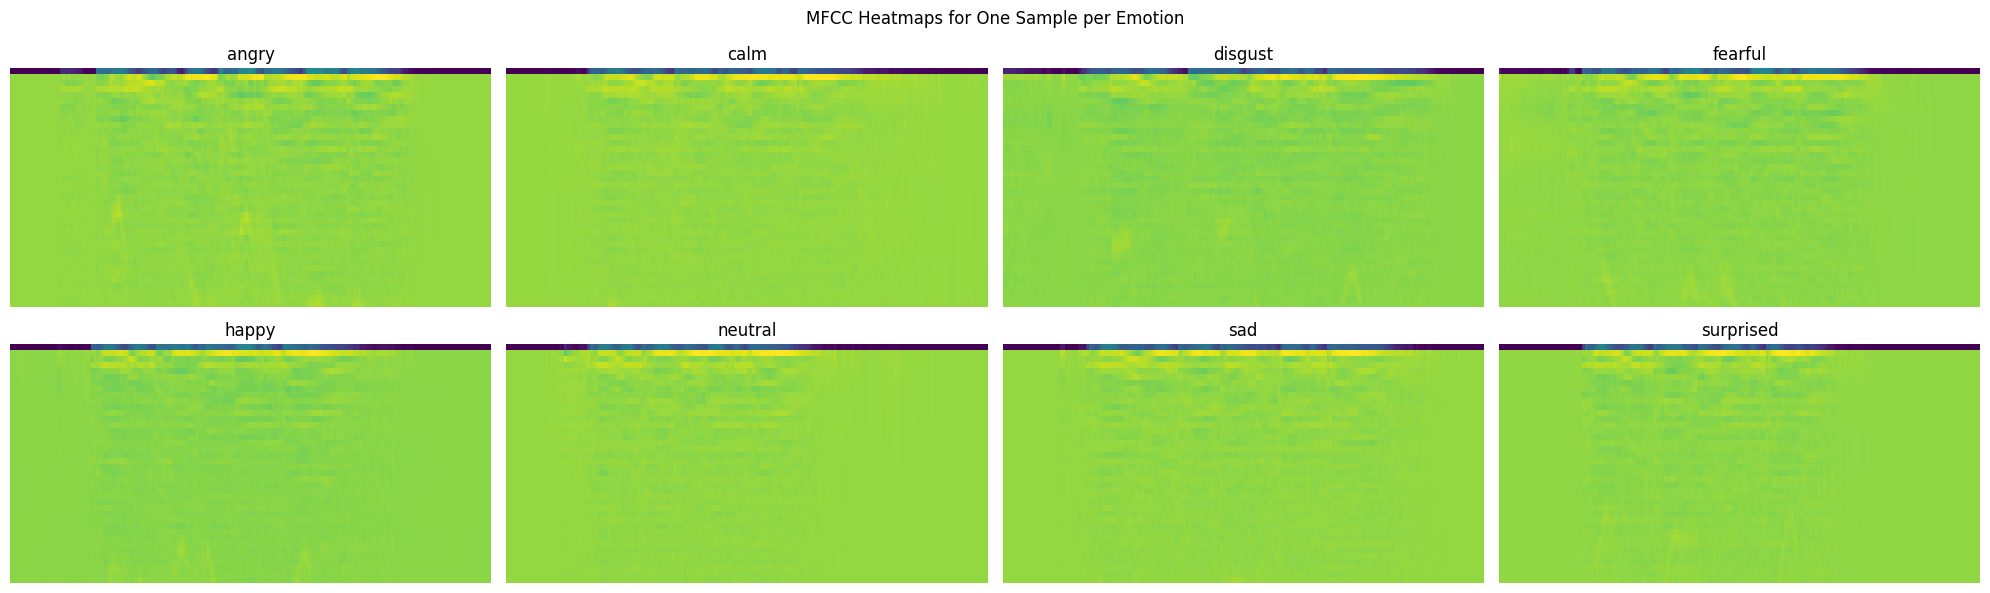

In [62]:
sample_per_emotion = df.groupby("emotion").first()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6))

for i, (emotion, row) in enumerate(sample_per_emotion.iterrows()):
    ax = axes[i // 4][i % 4]
    mfcc = row["mfcc_tensor"].T  # Transpose to (features x time)
    sns.heatmap(mfcc, ax=ax, cmap="viridis", cbar=False)
    ax.set_title(emotion)
    ax.axis('off')

plt.suptitle("MFCC Heatmaps for One Sample per Emotion")
plt.tight_layout()
plt.show()


In [4]:
# Stack all tensors into (N, T, F) shape
X_tensor = torch.stack(df["mfcc_tensor"].tolist())  # (N, 156, 40)

# Compute mean and std over all data (dim=0,1 combines all time and samples)
mean = X_tensor.mean(dim=(0, 1), keepdim=True)  # shape: (1, 1, 40)
std = X_tensor.std(dim=(0, 1), keepdim=True)    # shape: (1, 1, 40)

# Normalize
X_tensor_norm = (X_tensor - mean) / std


In [5]:
import torch
import pandas as pd
from sklearn.utils import shuffle

# Step 1: Label encode emotions
emotion_labels = sorted(df["emotion"].unique())
label_map = {e: i for i, e in enumerate(emotion_labels)}
df["label"] = df["emotion"].map(label_map)

# Ensure df has 'dataset' column with values 'speech' or 'song'
assert "dataset" in df.columns, "Expected 'dataset' column to indicate speech/song."

# Step 2: Initialize lists for train and val splits
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []

# Step 3: Group by dataset and emotion, then 80-20 split per group
for (dataset_type, emotion), group in df.groupby(["dataset", "emotion"]):
    label = label_map[emotion]
    features = torch.stack(group["mfcc_tensor"].tolist())
    labels = torch.tensor([label] * len(group))

    # Shuffle group
    features, labels = shuffle(features, labels, random_state=42)

    # 80-20 split
    split_idx = int(0.8 * len(group))
    X_train_list.append(features[:split_idx])
    y_train_list.append(labels[:split_idx])
    X_val_list.append(features[split_idx:])
    y_val_list.append(labels[split_idx:])

# Step 4: Combine all groups
X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
X_val = torch.cat(X_val_list, dim=0)
y_val = torch.cat(y_val_list, dim=0)

# Final check
print(f"Train size: {X_train.shape}, Validation size: {X_val.shape}")


Train size: torch.Size([1955, 184, 40]), Validation size: torch.Size([497, 184, 40])


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


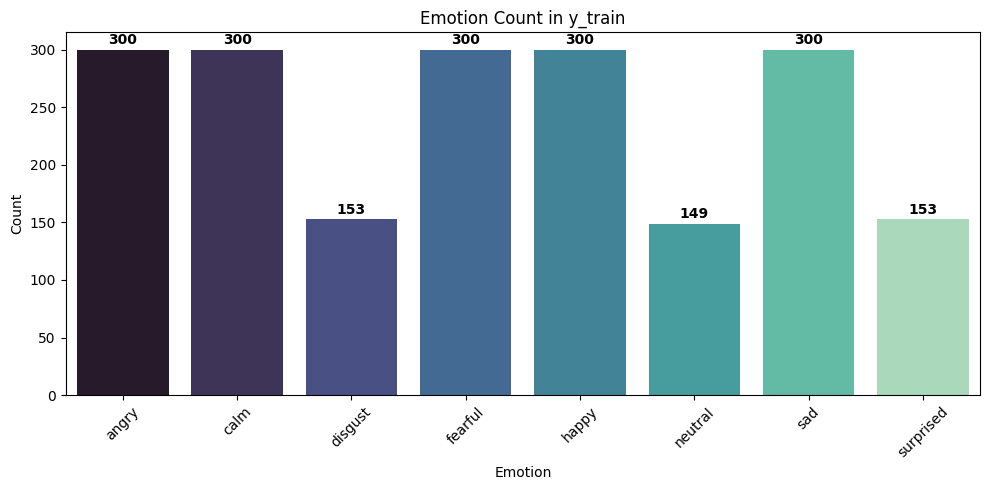

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count class occurrences in y_train
counts = Counter(y_train.numpy())

# Reverse label_map
idx_to_emotion = {v: k for k, v in label_map.items()}

# Get ordered labels and counts
emotion_names = [idx_to_emotion[i] for i in sorted(counts.keys())]
emotion_counts = [counts[i] for i in sorted(counts.keys())]

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=emotion_names, y=emotion_counts, palette="mako")

# Annotate each bar with its count
for i, count in enumerate(emotion_counts):
    ax.text(i, count + 2, str(count), ha='center', va='bottom', fontweight='bold')

plt.title("Emotion Count in y_train")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Reshape input tensors for CNN
X_train_cnn = X_train.unsqueeze(1)  # (N_train, 1, 156, 40)
X_val_cnn = X_val.unsqueeze(1)      # (N_val, 1, 156, 40)


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# If not using one-hot
train_dataset = TensorDataset(X_train_cnn, y_train)
val_dataset = TensorDataset(X_val_cnn, y_val)

# If using one-hot
# train_dataset = TensorDataset(X_train_cnn, y_train_oh)
# val_dataset = TensorDataset(X_val_cnn, y_val_oh)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN_SER(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_SER, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        # After conv layers, shape = (batch, 256, T', F')
        # Flatten time dimension to feed into LSTM
        self.lstm_input_size = 256 * 2   # Assuming T'=9, F'=1 after pooling
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=128,
                            batch_first=True,
                            bidirectional=True)

        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        # Input x: (B, 1, 156, 40)
        x = self.cnn(x)  # (B, 256, T', F')

        # Prepare for LSTM: collapse frequency dim, transpose time
        B, C, T, F = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()  # (B, T, C, F)
        x = x.view(B, T, -1)  # (B, T, C*F)

        # LSTM
        x, _ = self.lstm(x)  # (B, T, 256)
        x = x[:, -1, :]  # Last time step

        return self.fc(x)


In [10]:
num_classes = len(label_map)  # Typically 8 for RAVDESS
model = CRNN_SER(num_classes)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN_SER(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=100, save_path='best_model.pth'):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = correct / total

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
              f"Best Val Acc: {best_val_acc:.4f}")


In [13]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=100, save_path='crnn.pth')


Epoch 1/100 | Train Loss: 112.8450, Acc: 0.2711 | Val Loss: 28.0636, Acc: 0.3219 | Best Val Acc: 0.3219
Epoch 2/100 | Train Loss: 100.9106, Acc: 0.3540 | Val Loss: 23.5013, Acc: 0.4306 | Best Val Acc: 0.4306
Epoch 3/100 | Train Loss: 90.9437, Acc: 0.4225 | Val Loss: 29.9225, Acc: 0.3018 | Best Val Acc: 0.4306
Epoch 4/100 | Train Loss: 85.7364, Acc: 0.4558 | Val Loss: 21.7162, Acc: 0.4708 | Best Val Acc: 0.4708
Epoch 5/100 | Train Loss: 78.9288, Acc: 0.5223 | Val Loss: 19.0563, Acc: 0.5533 | Best Val Acc: 0.5533
Epoch 6/100 | Train Loss: 73.4021, Acc: 0.5468 | Val Loss: 19.2293, Acc: 0.5473 | Best Val Acc: 0.5533
Epoch 7/100 | Train Loss: 65.7887, Acc: 0.6184 | Val Loss: 18.8299, Acc: 0.5573 | Best Val Acc: 0.5573
Epoch 8/100 | Train Loss: 58.4769, Acc: 0.6624 | Val Loss: 18.9347, Acc: 0.5392 | Best Val Acc: 0.5573
Epoch 9/100 | Train Loss: 51.0919, Acc: 0.7028 | Val Loss: 21.8556, Acc: 0.5030 | Best Val Acc: 0.5573
Epoch 10/100 | Train Loss: 46.4388, Acc: 0.7315 | Val Loss: 12.7007, Ac

In [14]:
from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


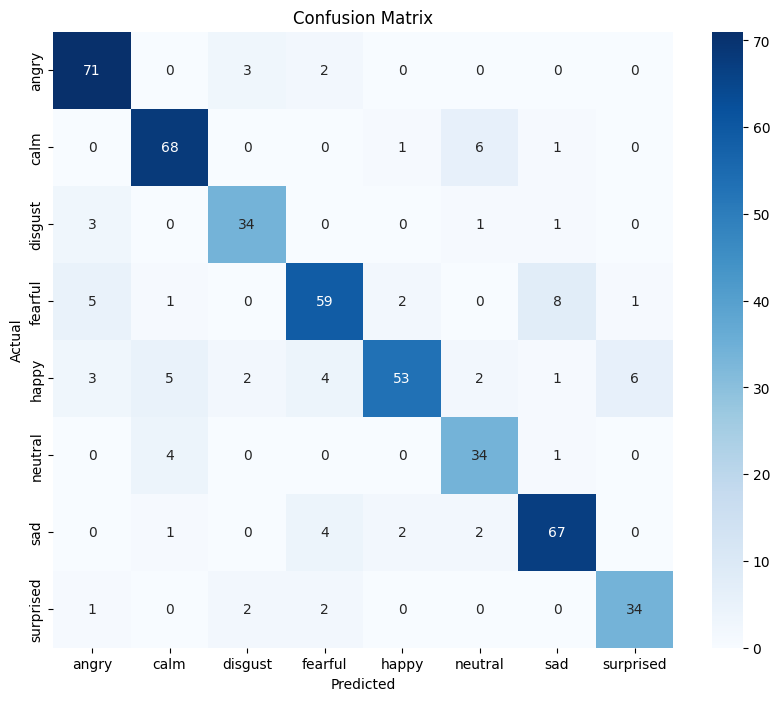

           precision  recall  f1-score  support
angry          0.855   0.934     0.893     76.0
calm           0.861   0.895     0.877     76.0
disgust        0.829   0.872     0.850     39.0
fearful        0.831   0.776     0.803     76.0
happy          0.914   0.697     0.791     76.0
neutral        0.756   0.872     0.810     39.0
sad            0.848   0.882     0.865     76.0
surprised      0.829   0.872     0.850     39.0

Overall F1 Scores:
Macro  F1-score:    0.8423
Weighted F1-score: 0.8436


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report as dictionary
report = classification_report(
    y_true, y_pred, target_names=emotion_names, output_dict=True, digits=3
)

# Convert to DataFrame
report_df = pd.DataFrame(report).T
per_class_metrics = report_df.iloc[:len(emotion_names)][["precision", "recall", "f1-score", "support"]]


# Display metrics
pd.set_option('display.precision', 3)
print(per_class_metrics)

# Print overall F1-scores
print("\nOverall F1 Scores:")
print(f"Macro  F1-score:    {report_df.loc['macro avg', 'f1-score']:.4f}")
print(f"Weighted F1-score: {report_df.loc['weighted avg', 'f1-score']:.4f}")
